# Image stitching

In [1]:
# Python Version 3.7
# OpenCV Version 4.1.2 
# Numpy Version 1.16.2
# Matplotlib Version 3.1.3
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt
import os

#pip install opencv-contrib-python

## Two images at a time choosing the Descriptor method (Sift, Brisk, Orb)

In [2]:
###############    Customized Image Stitching for Two images      #####################
class ImageStitching():
    
    def __init__(self) :
        self.ratio = 0.85
        self.min_match = 10
        self.smoothing_window_size=800        
        self.sift_descriptor = cv2.xfeatures2d.SIFT_create() # Sift descriptor
        self.brisk_descriptor = cv2.BRISK_create() # Brisk descriptor
        self.orb_descriptor = cv2.ORB_create() # Orb descriptor


    def detectAndDescribe(self, img, method):
        """Compute key points and feature descriptors using an specific method (sift, brisk, orb)"""
        # Descriptor method  Sift
        if method == 'sift': 
            return self.sift_descriptor.detectAndCompute(img,None)
        # Descriptor method  Brisk
        elif method == 'brisk': 
            return self.brisk_descriptor.detectAndCompute(img,None)
        # Descriptor method  Orb
        elif method == 'orb': 
            return self.orb_descriptor.detectAndCompute(img, None)


    def matchKeyPointsKNN(self,img1,img2, method):
        """ Features stration with descriptor select and Raw matches (knn)"""
        kp1, des1 = self.detectAndDescribe(img1, method)
        kp2, des2 = self.detectAndDescribe(img2, method) 
        
        
        matcher = cv2.BFMatcher()
        raw_matches = matcher.knnMatch(des1, des2, k=2)
        good_points = []
        good_matches=[]
        
        #Raw matches (knn)
        for m1, m2 in raw_matches:
            if m1.distance < self.ratio * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])
        img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
        
        
        if len(good_points) > self.min_match:
            # convert the keypoints to numpy arrays
            image1_kp = np.float32(
                [kp1[i].pt for (_, i) in good_points])
            image2_kp = np.float32(
                [kp2[i].pt for (i, _) in good_points])
            H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)
        else: # Number of points selected less than the limit
            return None
        
        return H, img3

    def createMask(self,img1,img2,version):
        """Create mask letf image and right image"""
        
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2
        offset = int(self.smoothing_window_size / 2)
        barrier = img1.shape[1] - int(self.smoothing_window_size / 2)
        mask = np.zeros((height_panorama, width_panorama))
        
        if version == 'left_image':
            mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
            mask[:, barrier + offset:] = 1
        return cv2.merge([mask, mask, mask])
    
    def stitchingImg(self,img1,img2, method):
        """  Main method for Stitching Image, descriptors method (sift, brisk, orb)"""
        #Features stration with descriptor select and Raw matches (knn)
        H, img3 = self.matchKeyPointsKNN(img1, img2, method)
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2

        # Join images  with mask
        panorama1 = np.zeros((height_panorama, width_panorama, 3))
        mask1 = self.createMask(img1,img2,version='left_image')
        panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
        panorama1 *= mask1
        mask2 = self.createMask(img1,img2,version='right_image')
        panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama))*mask2
        result=panorama1+panorama2
        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :]
        
        return final_result, img3

## Customized example Image Stitching   for Two images

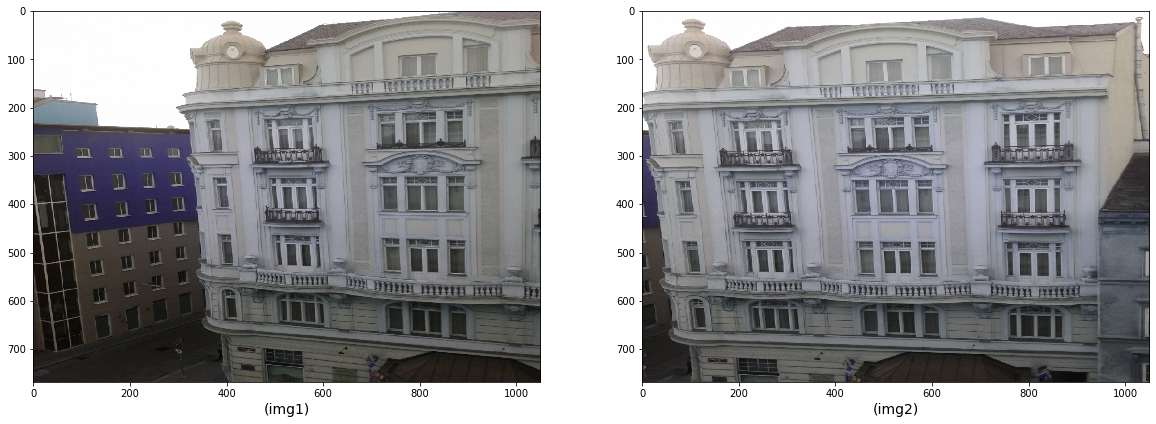

In [3]:
# Load images exeples
dim=(1050,768)
img1 = cv2.imread('images/image1.jpg')
img1 = cv2.resize(img1,dim,interpolation = cv2.INTER_AREA)

# Load image 2
img2 = cv2.imread('images/image2.jpg')
img2 = cv2.resize(img2,dim,interpolation = cv2.INTER_AREA)
# Plot imgas
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(img1)
ax1.set_xlabel("(img1)", fontsize=14)
ax2.imshow(img2)
ax2.set_xlabel("(img2)", fontsize=14)
plt.show()

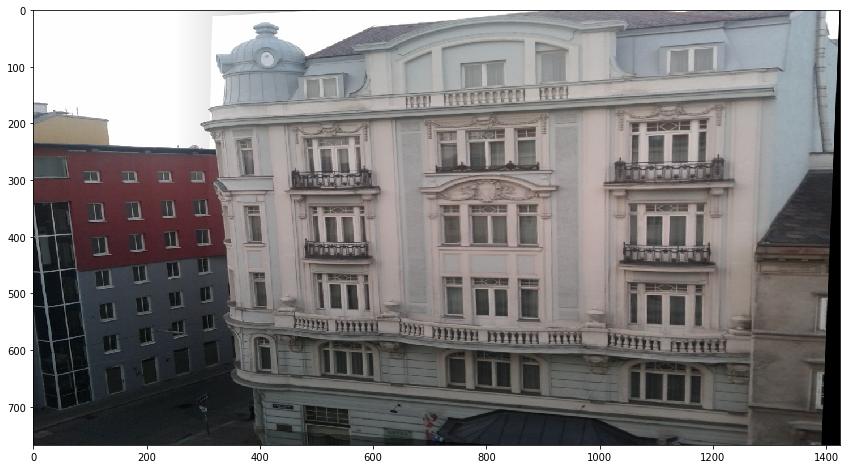

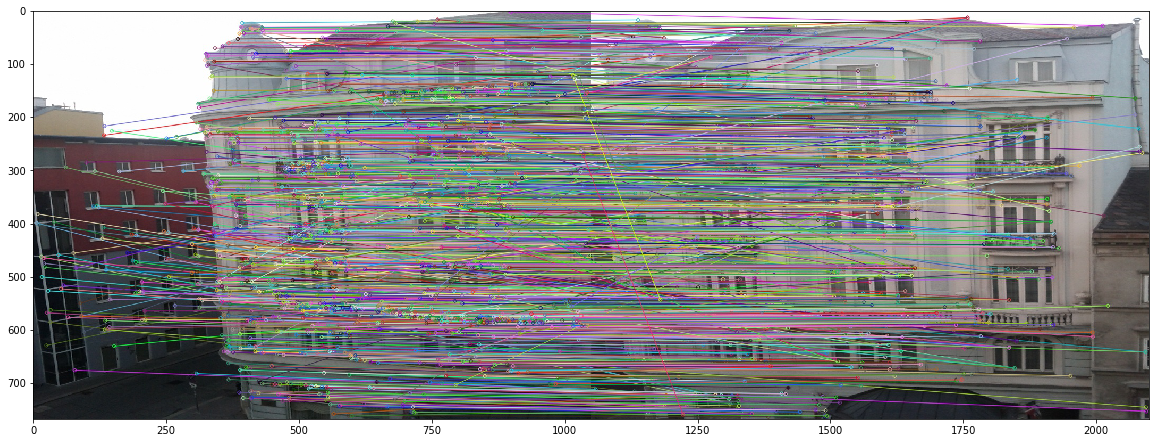

In [5]:
# Apply Method stitchingImg
method = 'sift'
path = 'imges_results/'
final, img3 =ImageStitching().stitchingImg(img1,img2, method)
cv2.imwrite(os.path.join(path,'panorama.jpg'), final)
cv2.imwrite(os.path.join(path, 'points.jpg'), img3)
# Plot results images
plt.figure(figsize=(20,8)) # image size
img_result = plt.imread(path+'panorama.jpg')
plt.imshow(img_result)
plt.show()
plt.figure(figsize=(20,8)) # image size
ponts_result = plt.imread(path+'points.jpg')
plt.imshow(ponts_result)
plt.show()

## Image stitching with OpenCv

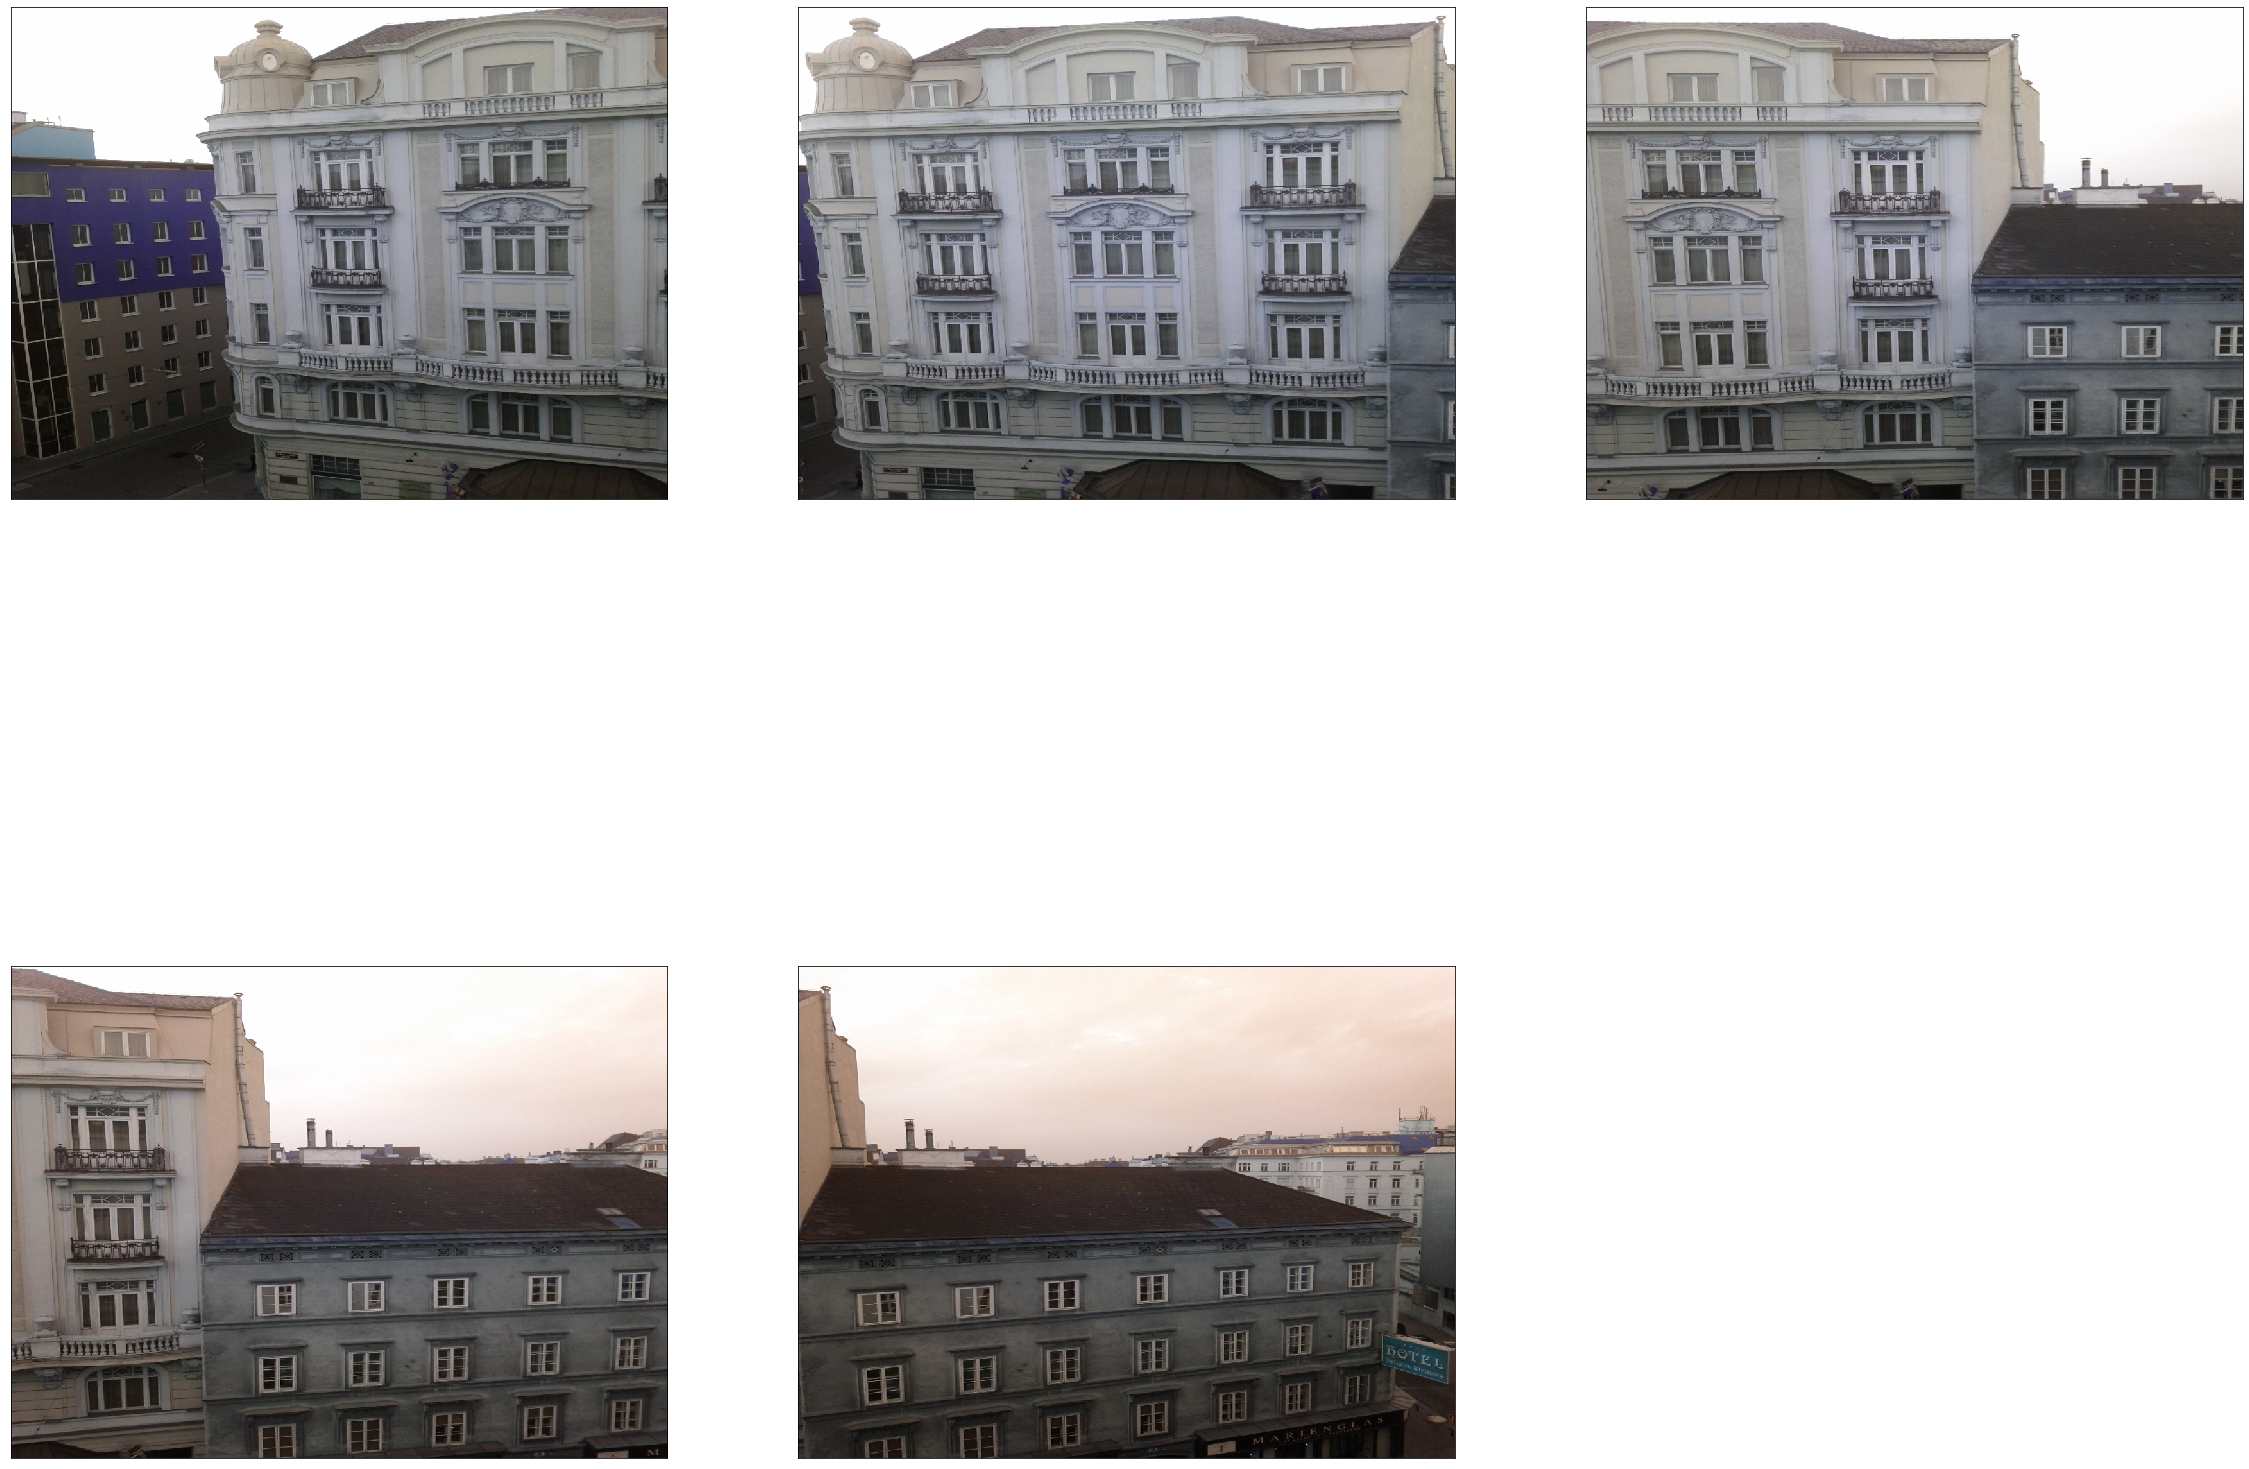

In [6]:
# Diretory images
images_path = 'images/'
dire_images = os.listdir(images_path)
list_dire_images = [] #full image directory
for i in dire_images:
    list_dire_images.append(images_path+i)
    
# Input images
images_input = []
for i in list_dire_images:
    dim=(1024,768)
    img = cv2.imread(i,cv2.IMREAD_COLOR)
    img = cv2.resize(img,dim,interpolation = cv2.INTER_AREA)
    images_input.append(img)   
    
def plotImages(list_imgs):
    """Subplot images"""
    plt.figure(figsize=(40,50)) # image size
    for i in range(len(list_imgs)):
        plt.subplot(3,3,i+1) # Every two images
        plt.xticks([])
        plt.yticks([])
        plt.grid(True)
        img = list_imgs[i]
        plt.imshow(img, cmap="gray")
    plt.show()
# Plot all images input
plotImages(images_input)  

In [7]:
# Exemplen Image stitching with OpenCv for multiple Images
def stitchingOpencv(list_dire_images):
    """ Image stitching with OpenCv for multiple Images"""
    list_imgs = []
    for i in list_dire_images:
        dim=(1030,770) # Size image
        img = cv2.imread(i,cv2.IMREAD_COLOR) # Load image
        img = cv2.resize(img,dim,interpolation = cv2.INTER_AREA) # image resize with iterpolation
        list_imgs.append(img)
    stitching = cv2.Stitcher.create()
    status,output_img = stitching.stitch(list_imgs)
    return status, output_img

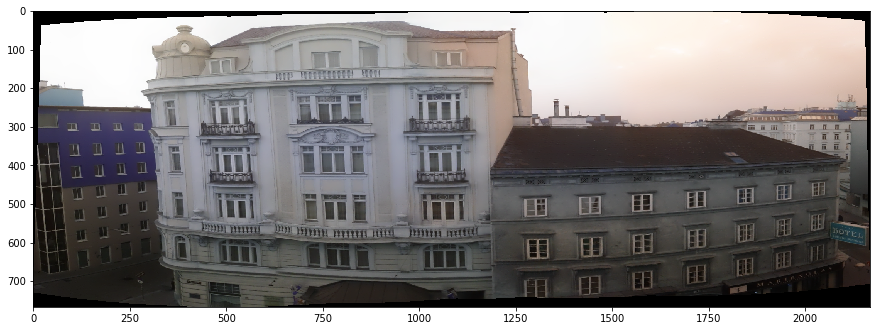

In [8]:
# Applying the Opencv stitching function
status,output_img = stitchingOpencv(list_dire_images)
cv2.imwrite(os.path.join(path,'all_panorama.jpg'), output_img)
plt.figure(figsize=(15,9))
plt.imshow(output_img)
plt.show()